In [1]:
import pandas as pd
import numpy as np
import json
import glob

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim


In [2]:
df = pd.read_pickle('long_gcse_specs.pkl')

In [3]:
import pandas as pd

# Assuming your DataFrame is named df and the text is in the 'Text' column

# Define the patterns to remove
patterns_to_remove = ['the nature of', 'the nature and', 'the nature,', 'the nature a nd', 'th e nature of', 'the  nature and', 't he nature and', 'the  nature and', 'the  nature of', 'the nature of', 'the nature an d' ]

# Combine the patterns into a single regular expression
combined_pattern = '|'.join(patterns_to_remove)

# Replace the patterns with an empty string
df['Text'] = df['Text'].str.replace(combined_pattern, '', case=False, regex=True)


In [4]:
from gensim import corpora

# Step 1: Generate data_words
data_words = df['Processed_Text'].apply(lambda x: x.split()).tolist()

# Step 2: Create id2word dictionary
id2word = corpora.Dictionary(data_words)

# Step 3: Create the corpus
corpus = [id2word.doc2bow(text) for text in data_words]


In [5]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=75)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=75)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

remove_word = "signature"

# Filter out the specific word
data_bigrams_trigrams = [[word for word in doc if word != remove_word] for doc in data_bigrams_trigrams]

In [6]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]
# print (corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.02
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

In [4]:
 lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=9,          
                                            random_state=10,      
                                            update_every=1,        
                                            chunksize=10,          
                                            passes=50,
                                             eta=0.001,
                                            alpha=0.1)   

NameError: name 'gensim' is not defined

In [54]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

C:\Users\Asha\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.383595  0.179221       1        1  25.470635
8      0.412817 -0.145168       2        1  15.153865
6      0.142491  0.437589       3        1  14.871654
3     -0.172496 -0.400678       4        1  11.834115
4     -0.174643  0.358868       5        1   9.990319
5      0.210142 -0.422422       6        1   7.418829
1     -0.398815  0.184770       7        1   6.307557
0      0.020170 -0.062963       8        1   4.987854
7     -0.423260 -0.129216       9        1   3.965171, topic_info=               Term          Freq         Total Category  logprob  loglift
1115           tier  10748.000000  10748.000000  Default  30.0000  30.0000
608        language   3361.000000   3361.000000  Default  29.0000  29.0000
2028         medium   1902.000000   1902.000000  Default  28.0000  28.0000
1476     vocabulary   2832.000000   2832.000000  Default  27.0000  27.0000
3891           verb   2513.000000   2513.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
1602       non_exam     65.759367    406.764984   Topic9  -4.3974   1.4054
1985  investigation     37.751896    224.900970   Topic9  -4.9524   1.4430
1099      technique     40.433129   1112.745102   Topic9  -4.8837  -0.0873
796       practical     41.086260   2843.787052   Topic9  -4.8677  -1.0096
475        function     34.228858    308.783373   Topic9  -5.0503   1.0281

[411 rows x 6 columns], token_table=      Topic      Freq                           Term
term                                                
3768      4  1.005234               accidence_syntax
1207      7  0.984333  accurate_spelling_punctuation
3770      4  0.999998                      adjective
3771      4  1.000004                         adverb
50        3  1.002604                        analyse
...     ...       ...                            ...
2625      6  0.026325                          water
2283      3  0.997193                          woman
1479      7  0.987883                    word_phrase
1481      7  0.993492                         writer
1482      7  1.000427                        writing

[424 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 7, 4, 5, 6, 2, 1, 8])

In [55]:
from gensim.models import CoherenceModel

# Assuming lda_model is your trained LDA model, and texts is your list of tokenized documents
coherence_model_umass = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
coherence_umass = coherence_model_umass.get_coherence()

coherence_model_cv = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_cv = coherence_model_cv.get_coherence()

print(f'Coherence UMass: {coherence_umass}')
print(f'Coherence C_v: {coherence_cv}')

Coherence UMass: -4.235543603566871
Coherence C_v: 0.5967143257939337


In [59]:
# Print the top words for all topics to verify their numbers
for topic_id in range(lda_model.num_topics):
    print(f"Topic {topic_id}:")
    print(lda_model.print_topic(topic_id))


Topic 0:
0.080*"music" + 0.067*"piece" + 0.058*"perform" + 0.056*"musical" + 0.045*"composition" + 0.025*"note" + 0.021*"musical_element" + 0.020*"instrument" + 0.020*"control" + 0.017*"brief"
Topic 1:
0.211*"theme" + 0.127*"writing" + 0.081*"text" + 0.069*"point_view" + 0.064*"play" + 0.058*"effectively" + 0.047*"extract" + 0.027*"sentence" + 0.021*"reading" + 0.021*"read"
Topic 2:
0.082*"practical" + 0.057*"datum" + 0.049*"energy" + 0.049*"force" + 0.042*"calculation" + 0.034*"reaction" + 0.033*"property" + 0.032*"investigate" + 0.032*"equation" + 0.027*"water"
Topic 3:
0.178*"vocabulary" + 0.158*"verb" + 0.119*"sentence" + 0.081*"noun" + 0.068*"tier" + 0.052*"speak" + 0.048*"adjective" + 0.028*"grammar" + 0.027*"infinitive" + 0.023*"spanish"
Topic 4:
0.151*"component" + 0.096*"audience" + 0.086*"text" + 0.032*"meaning" + 0.031*"technique" + 0.030*"production" + 0.026*"presentation" + 0.025*"drama" + 0.024*"non_exam" + 0.019*"recording"
Topic 5:
0.057*"fieldwork" + 0.055*"human" + 0.

In [20]:
 import re
from gensim.models import LdaModel

# Get the topic distribution for each document
topic_distributions = lda_model.get_document_topics(corpus)

# Define the topic ID and word to search for
topic_id = 3  # Replace with the actual topic ID
search_word = "nature"

# Number of top documents to retrieve and inspect
num_top_docs = 20

# Extract topic proportions for each document
doc_topic_probs = [(doc_id, dict(doc_topics).get(topic_id, 0)) for doc_id, doc_topics in enumerate(topic_distributions)]

# Sort documents by topic probability in descending order
sorted_docs = sorted(doc_topic_probs, key=lambda x: x[1], reverse=True)

# Assign the top documents to the top_docs variable
top_docs = sorted_docs[:num_top_docs]

# Print the top documents for the specified topic with additional metadata
print(f"Top {num_top_docs} documents for Topic {topic_id}:")
for doc_id, prob in top_docs:
    author = df.loc[doc_id, 'Author']
    subject = df.loc[doc_id, 'Subject']
    original_text = df.loc[doc_id, 'Text']
    file_name = df.loc[doc_id, 'File_Name']
    
    print(f"Document ID: {doc_id}, Topic Probability: {prob}")
    print(f"Author: {author}")
    print(f"Subject: {subject}")
    print(f"File Name: {file_name}")
    print("-" * 50)

def find_sentences_with_word(doc, word):
    # Split the document into sentences
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', doc)
    highlighted_sentences = []
    # Iterate over each sentence
    for sentence in sentences:
        if word.lower() in sentence.lower():
            # Highlight the word by wrapping it with ANSI escape codes
            highlighted_sentence = re.sub(f"(?i)({word})", r'\033[91m\1\033[0m', sentence)
            highlighted_sentences.append(highlighted_sentence)
    return highlighted_sentences

# Extract and print sentences containing the word from the top documents
for doc_id, prob in top_docs[:10]:  # Inspecting the top 10 documents
    # Retrieve the unprocessed text of the document from the DataFrame
    document_text = df.loc[doc_id, 'Text']
    
    # Retrieve other relevant information from the DataFrame
    author = df.loc[doc_id, 'Author']
    subject = df.loc[doc_id, 'Subject']
    file_name = df.loc[doc_id, 'File_Name']
    
    # Find sentences containing the word and highlight it
    sentences_with_word = find_sentences_with_word(document_text, search_word)
    
    # Print the document ID and the sentences that contain the word
    print(f"Document ID: {doc_id}, Topic Probability: {prob}")
    print(f"Author: {author}")
    print(f"Subject: {subject}")
    print(f"File Name: {file_name}")
    for sentence in sentences_with_word:
        print(f"Sentence: {sentence}")
    print()


Top 20 documents for Topic 3:
Document ID: 55, Topic Probability: 0.999981701374054
Author: AQA
Subject: Religious Studies
File Name: specification-gcse-l1-l2-religious-studies-b-june-2016-draft-4.pdf
--------------------------------------------------
Document ID: 54, Topic Probability: 0.9999614953994751
Author: AQA
Subject: Religious Studies
File Name: specification-gcse-l1-l2-religious-studies-a-june-2016-draft-4.pdf
--------------------------------------------------
Document ID: 22, Topic Probability: 0.9999560713768005
Author: AQA
Subject: Religious Studies
File Name: 240547-specification-accredited-gcse-religious-studies-j625.pdf
--------------------------------------------------
Document ID: 70, Topic Probability: 0.9999291896820068
Author: Pearson Edexcel
Subject: Geography A
File Name: Specification_GCSE_L1-L2_Geography_B.pdf
--------------------------------------------------
Document ID: 47, Topic Probability: 0.9804296493530273
Author: Pearson Edexcel
Subject: Geography A
Fi

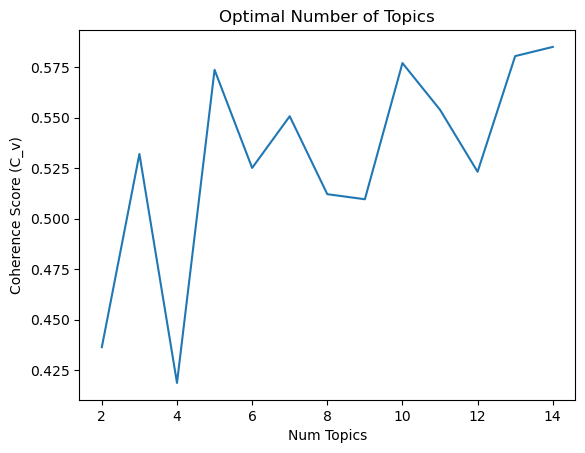

In [29]:
coherence_values = []
model_list = []
for num_topics in range(2, 15, 1):
    model = gensim.models.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=50, random_state=100, update_every=1,        
                                            chunksize=10, eta=0.01, alpha="auto")
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())

# Plot coherence scores
import matplotlib.pyplot as plt

plt.plot(range(2, 15, 1), coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score (C_v)")
plt.title("Optimal Number of Topics")
plt.show()

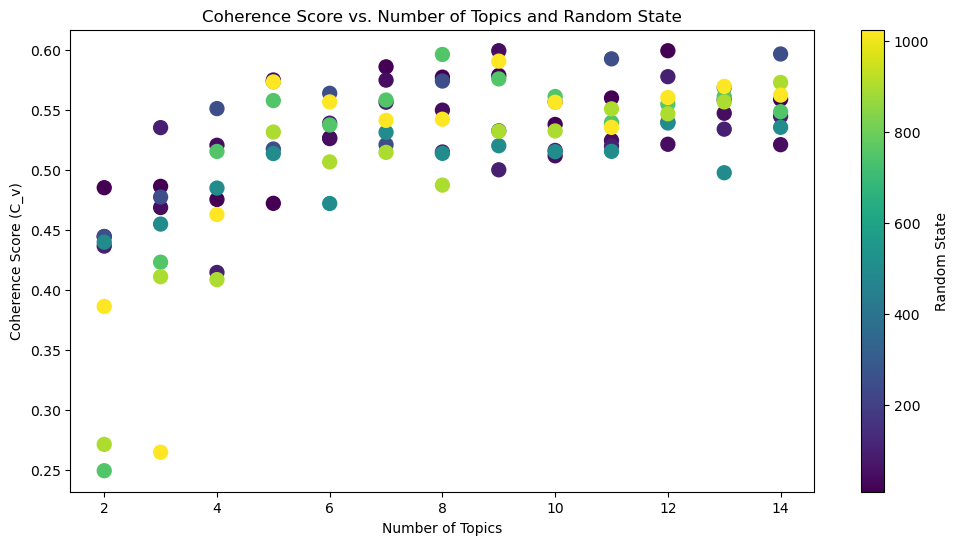

In [51]:
# Define ranges for parameters
random_states = [10, 42, 100, 250, 500, 750, 900, 1024]
# Initialize lists to store results
coherence_values = []
params = []

for num_topics in range(2, 15, 1):
    for random_state in random_states:
        model = gensim.models.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=50, random_state=random_state, update_every=1,        
                                            chunksize=10, eta=0.001, alpha="auto")
        coherence_model = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=id2word,
            coherence='c_v'
        )
        coherence_score = coherence_model.get_coherence()
        coherence_values.append(coherence_score)
        params.append((num_topics, random_state))

# Convert to numpy arrays for easier plotting
coherence_values = np.array(coherence_values)
params = np.array(params)

# Plot coherence scores
plt.figure(figsize=(12, 6))
scatter = plt.scatter(params[:, 0], coherence_values, c=params[:, 1], cmap='viridis', s=100)
plt.colorbar(scatter, label='Random State')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score (C_v)')
plt.title('Coherence Score vs. Number of Topics and Random State')
plt.show()